In [1]:
import tensorflow as tf
import shap
shap.initjs()

import sklearn
import numpy as np
import pandas as pd
import os, sys
import keras
from sklearn.utils import resample
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.simplefilter(action='ignore')

Using TensorFlow backend.


## Load Data

In [2]:
X = pd.read_csv('./income_X.csv')
y = pd.read_csv('income_Y.csv').to_numpy()[:,1].reshape(-1,).astype(int)
X.shape, y.shape

((32561, 12), (32561,))

In [3]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [4]:
X.describe()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,3.868892,10.080679,2.611836,6.572740,2.494518,3.665858,0.669205,1077.648844,87.303830,40.437456,36.718866
std,13.640433,1.455960,2.572720,1.506222,4.228857,1.758232,0.848806,0.470506,7385.292085,402.960219,12.347429,7.823782
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,4.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,39.000000
50%,37.000000,4.000000,10.000000,2.000000,7.000000,3.000000,4.000000,1.000000,0.000000,0.000000,40.000000,39.000000
75%,48.000000,4.000000,12.000000,4.000000,10.000000,4.000000,4.000000,1.000000,0.000000,0.000000,45.000000,39.000000
max,90.000000,8.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [6]:
def get_stats(model, x_test_input=X_test, y_test_input=y_test,
             x_train_inp=X_train, y_train_inp=y_train):
    y_pred = np.round(model.predict(x_test_input))
    y_pred_train = np.round(model.predict(x_train_inp))
    accuracy_test = sklearn.metrics.accuracy_score(y_test_input, y_pred)
    accuracy_train = sklearn.metrics.accuracy_score(y_train_inp, y_pred_train)
    print("Accuracy Test: {0}".format(round(accuracy_test, 3)))
    print("Accuracy Train: {0}".format(round(accuracy_train, 3)))
    print(classification_report(y_test_input, y_pred))

## Train Models

### Train Logistic Regression model and print feature influences

In [7]:
#scaling the data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

#fit the LogisticRegression
log_reg = LogisticRegression(solver = 'lbfgs',max_iter=3000, random_state = 7)
log_reg.fit(X_train_s, y_train)
y_pred_log = log_reg.predict(X_test_s)

In [8]:
#metrics LogisticRegression
get_stats(log_reg, x_test_input=X_test_s, y_test_input=y_test,
             x_train_inp=X_train_s, y_train_inp=y_train)

Accuracy Test: 0.84
Accuracy Train: 0.841
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4951
           1       0.72      0.55      0.62      1562

    accuracy                           0.84      6513
   macro avg       0.79      0.74      0.76      6513
weighted avg       0.83      0.84      0.83      6513



The importance of a feature in a linear regression model can be measured by the absolute value of its t-statistic. The t-statistic is the estimated weight scaled with its standard error.

$t_{\hat{β}_j} = \frac {\hat{β}_j}{SE(β_{j})} 
$

The importance of a feature increases with increasing weight. This makes sense. The more variance the estimated weight has (= the less certain we are about the correct value), the less important the feature is. This also makes sense.

In [9]:
log_reg.coef_[0]

array([ 0.45292396, -0.03147321,  0.94255498, -0.24720479,  0.07479368,
        0.95929842,  0.09332778,  0.27440935,  2.48446723,  0.28632354,
        0.41246497,  0.03433746])

In [10]:
#collecting all metrics of feauter influence into df
coef_df = pd.DataFrame(log_reg.coef_[0], index = X.columns.to_list(), 
                       columns = ['Coefficient']).sort_values(by = 'Coefficient')

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [11]:
err = np.std([log_reg.fit(*resample(X, y)).coef_[0] for i in range(100)], 0)

coef_df['err'] = err

coef_df['t'] =  coef_df['Coefficient'] / coef_df['err']

In [12]:
importance = coef_df.sort_values(by = 'Coefficient', ascending=False).copy()

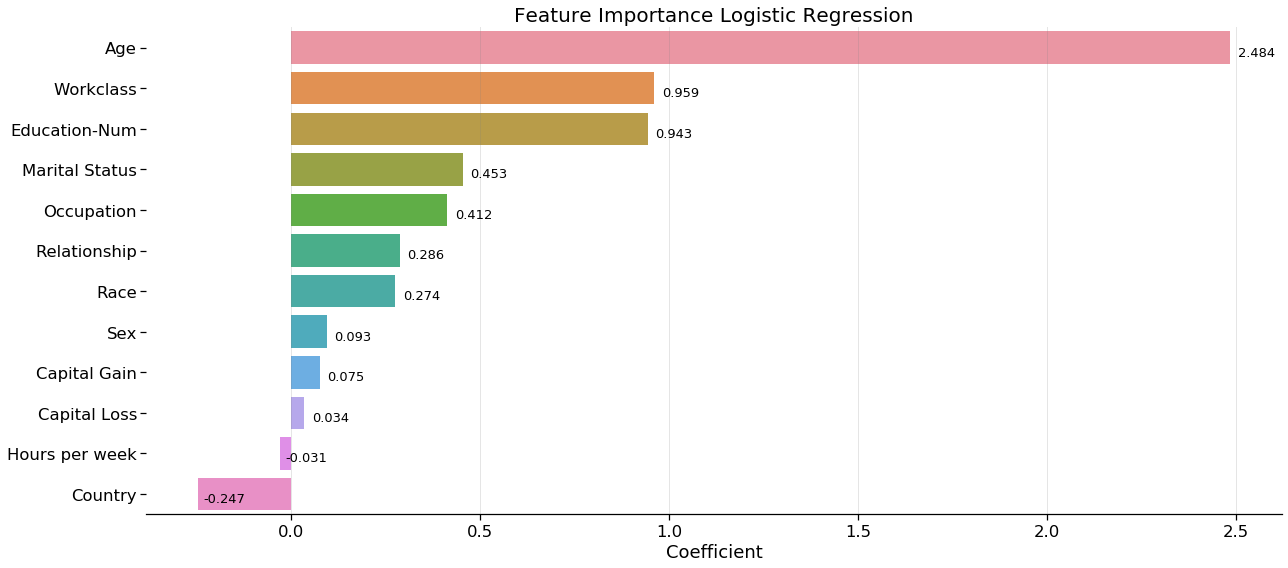

In [13]:
fig, (ax2) = plt.subplots(figsize = (18,8))

g = sns.barplot(importance.Coefficient,X.columns.to_list())
g.set_title('Feature Importance Logistic Regression', fontsize = 20);

for p in g.patches:
    width = p.get_width()
    g.text(width +0.0700  ,
            p.get_y()+ p.get_height()/2+0.2 ,
            f'{(width).round(3)}',
            ha="center", size=13)
ax2.grid(axis='x',which='major',color='grey', alpha=0.2)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
plt.tight_layout()

### Train Random Forest model and print feature influence


In [14]:
#scaling the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

#fit the random forest classifier
rfc = RandomForestClassifier(max_depth=5, n_estimators=200) 
rfc.fit(X_train_sc, y_train)
y_pred_rfc = rfc.predict(X_test_sc)

In [15]:
#metrics random forest classifier
get_stats(rfc, x_test_input=X_test_sc, y_test_input=y_test,
             x_train_inp=X_train_sc, y_train_inp=y_train)

Accuracy Test: 0.856
Accuracy Train: 0.856
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4951
           1       0.80      0.53      0.64      1562

    accuracy                           0.86      6513
   macro avg       0.83      0.75      0.78      6513
weighted avg       0.85      0.86      0.85      6513



In [16]:
rfc.feature_importances_

array([0.06840434, 0.00217958, 0.16092087, 0.13147781, 0.0188637 ,
       0.29714694, 0.00079947, 0.01951155, 0.21449057, 0.04270987,
       0.04258963, 0.00090568])

In [17]:
#collecting all influence metrics into df
coef_forest = pd.DataFrame(rfc.feature_importances_, index = X.columns.to_list(), 
                       columns = ['Coefficient']).sort_values(by = 'Coefficient')

In [18]:
err_forest = np.std([rfc.fit(*resample(X, y)).feature_importances_ for i in range(100)], 0)

coef_forest['err'] = err_forest

coef_forest['t'] =  coef_forest['Coefficient'] / coef_forest['err']

coef_forest.sort_values(by = 't')
coef_forest

,Coefficient,err,t
Race,0.000799,0.005847,0.136740
Country,0.000906,0.000467,1.941329
Workclass,0.002180,0.009842,0.221466
Occupation,0.018864,0.012590,1.498286
Sex,0.019512,0.002637,7.399215
Hours per week,0.042590,0.015451,2.756415
Capital Loss,0.042710,0.000223,191.818743
Age,0.068404,0.003007,22.749719
Marital Status,0.131478,0.010388,12.656096
Education-Num,0.160921,0.004166,38.625324


In [19]:
importance_tree = coef_forest.sort_values(by = 'Coefficient', ascending=False).copy()

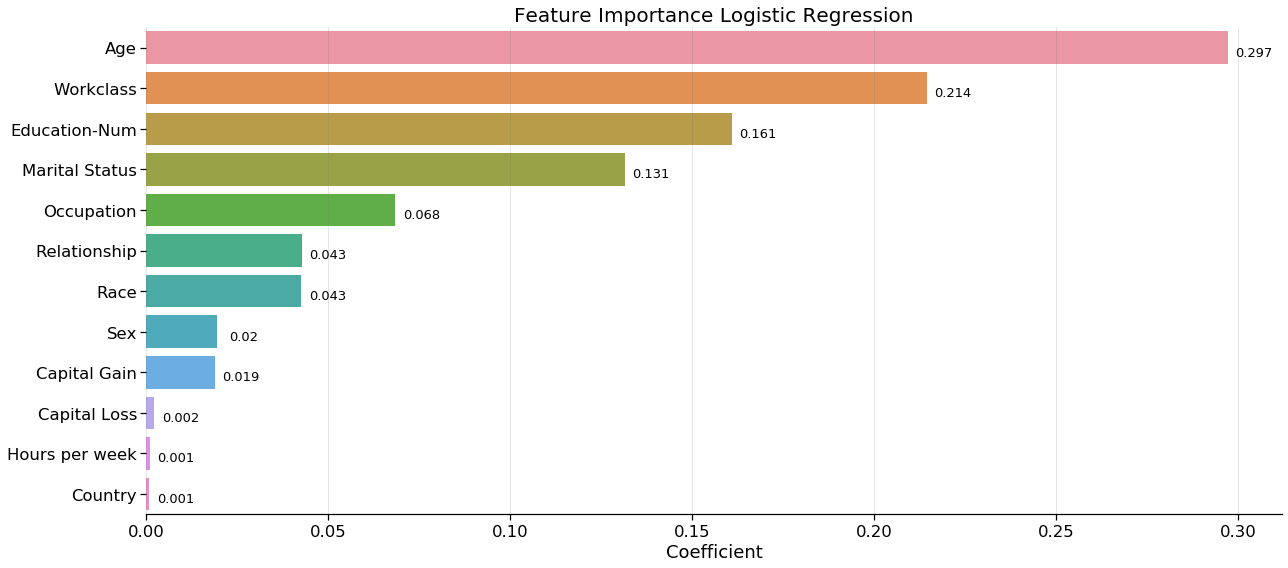

In [20]:
fig, ( ax2) = plt.subplots(figsize = (18,8))

g = sns.barplot(importance_tree.Coefficient,X.columns.to_list())
g.set_title('Feature Importance Logistic Regression', fontsize = 20);

for p in g.patches:
    width = p.get_width()
    g.text(width +0.00712  ,
            p.get_y()+ p.get_height()/2+0.2 ,
            f'{width.round(3)}',
            ha="center", size=13)
ax2.grid(axis='x',which='major',color='grey', alpha=0.2)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
plt.tight_layout()

## Explainability

### Using SHAP, explain the decision made by your model on one instance.


In [21]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)

Expected Value: [0.75700439 0.24299561]


In [22]:
X_test.iloc[22,:]

Age               17.0
Workclass          4.0
Education-Num      7.0
Marital Status     4.0
Occupation        12.0
Relationship       3.0
Race               4.0
Sex                0.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    35.0
Country           39.0
Name: 3935, dtype: float64

In [23]:
# Predicting when a person’s income <= $50K
shap.force_plot(explainer.expected_value[0], shap_values[0][22], X_test.iloc[22,:])

On the plot we can see that a person 17 years old with only 7 years education, who never was merried and not in the family, works 35hours per week and Capital gain = 0 almost have no chances to have income > 50K

these features increase the probability of that this person has incom <=50K
<br>The only one feature Ocupation increase the probability of having an income >50K and decrease the probability that this person has incom <=50K

The plot below is reversed with the same instance (it is for have income > 50K)

In [32]:
# Predicting when a person’s income > $50K
shap.force_plot(explainer.expected_value[1], shap_values[1][22], X_test.iloc[22,:])

Let's look on the summary plot

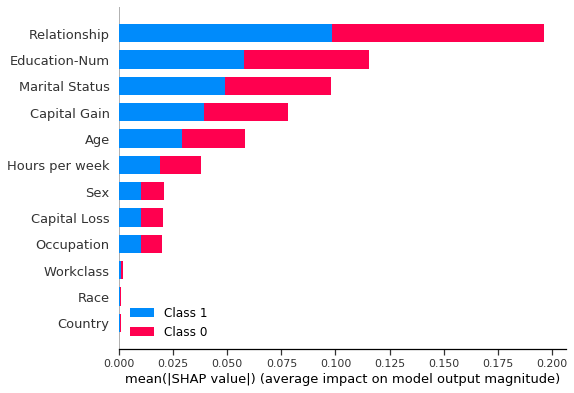

In [25]:
shap.summary_plot(shap_values, X_test)

The features are sorted by mean(|Tree SHAP|) and so we see the Relationship feature as the strongest predictor of making over $50K annually.

On this plot we see, that Relationship, Education, Marital status, Capital Gain and Age can significantly increase or decrease the probability of prediction. In average these features have more influence on  the model's decision in prediction 

### Using SHAP, explain how the prediction value changes depending on the value of one variable.


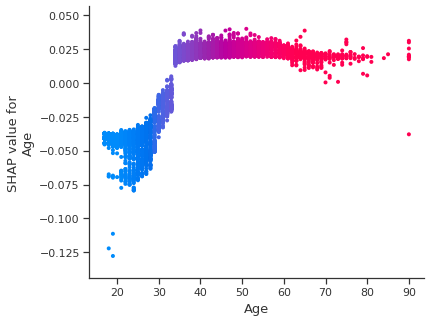

In [34]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test)

On this plot we can see the clear impact of age on earning potential as captured by our model.
The coloring by feature value shows us patterns such as how being younger lowers your chance of making over 50K, while higher education increases your chance of making over $50K.


Many people in the data set are 20 years old, how much their age impacts their prediction differs as shown by the vertical dispersion of dots at age 20. This means other features are impacting the importance of age. To see what feature might be part of this effect we color the dots by the number of years of education and see that a high level of education lowers the effect of age in your 20’s, but raises it in your 30's:

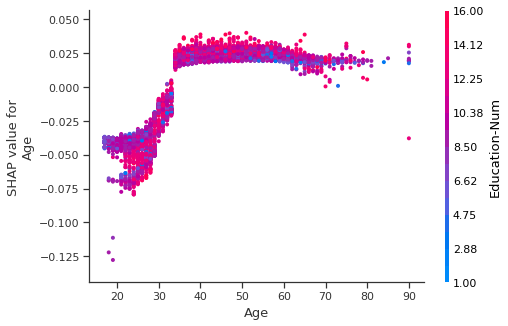

In [27]:
shap.dependence_plot(ind='Age', interaction_index='Education-Num',
                     shap_values=shap_values[1], 
                     features=X_test,  
                     display_features=X_test)

In [28]:
# Visualizing and explaining multiple predictions by age
shap.force_plot(explainer.expected_value[0], 
                shap_values[0][:1000,:], X_test.iloc[:1000,:])

### Using Lime explain the decision made by your model on one instance.

In [29]:

exp = LimeTabularExplainer(X_test.values, feature_names=list(X.columns), training_labels = y_train,
                           discretize_continuous=True, 
                           class_names=['$50K or less', 'More than $50K'])

In [30]:
doc_num = 22

print('Actual Label:', y_test[doc_num])
print('Predicted Label:', y_pred_rfc[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, rfc.predict_proba).show_in_notebook()

Actual Label: 0
Predicted Label: 0


On this plot we see, that our model made a correct prediction for the person with income 50K or less with probability value 0.99. We have here only 2 features which increase the probability of income more than 50K with a very small weight(Country 0.05 and Occupation 0.02), the rest of features are pointing on that the person definitely have no such income. The feature Capital Gain is the main influencer here on the model's prediction

We already saw this instance in question with shap, but now we also able to see the Interpretability of the our model in  more intuitive way. Also we have here more information: in shap we didn't saw features Country and Sex